In [5]:
import pandas as pd
import glob
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import os
import sys
sys.path.append(os.path.abspath('../src'))
from loader import load_news_data




In [2]:
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()


In [7]:
news = load_news_data('../data/raw_analyst_ratings.csv')
news['date'] = pd.to_datetime(news['date'], errors='coerce').dt.date



Loading data from ../data/raw_analyst_ratings.csv...


In [8]:
def get_textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

news['textblob_sentiment'] = news['headline'].apply(get_textblob_sentiment)


In [9]:
news['vader_sentiment'] = news['headline'].apply(lambda x: sia.polarity_scores(str(x))['compound'])



In [10]:
daily_sentiment = news.groupby(['stock','date'])[['textblob_sentiment','vader_sentiment']].mean().reset_index()



In [14]:
files = glob.glob("../data/stock/*.csv")

stock_dfs = []
for f in files:
    ticker = os.path.splitext(os.path.basename(f))[0]   # clean ticker
    df = pd.read_csv(f)
    df['date'] = pd.to_datetime(df['Date']).dt.date
    df['stock'] = ticker
    df['daily_return'] = df['Close'].pct_change()
    stock_dfs.append(df[['date','stock','Close','daily_return']])

stocks = pd.concat(stock_dfs, ignore_index=True)
print(stocks.head())




         date stock     Close  daily_return
0  2009-01-02  AAPL  2.721686           NaN
1  2009-01-05  AAPL  2.836553      0.042204
2  2009-01-06  AAPL  2.789767     -0.016494
3  2009-01-07  AAPL  2.729484     -0.021609
4  2009-01-08  AAPL  2.780169      0.018570


In [15]:
merged = pd.merge(stocks, daily_sentiment, on=['stock','date'], how='inner')

In [16]:

pearson_corr = merged[['textblob_sentiment','vader_sentiment','daily_return']].corr(method='pearson')
spearman_corr = merged[['textblob_sentiment','vader_sentiment','daily_return']].corr(method='spearman')
kendall_corr = merged[['textblob_sentiment','vader_sentiment','daily_return']].corr(method='kendall')

print("Pearson Correlation:\n", pearson_corr, "\n")
print("Spearman Correlation:\n", spearman_corr, "\n")
print("Kendall Correlation:\n", kendall_corr, "\n")



Pearson Correlation:
                     textblob_sentiment  vader_sentiment  daily_return
textblob_sentiment            1.000000         0.704667      0.160660
vader_sentiment               0.704667         1.000000      0.170882
daily_return                  0.160660         0.170882      1.000000 

Spearman Correlation:
                     textblob_sentiment  vader_sentiment  daily_return
textblob_sentiment            1.000000         0.703857      0.063274
vader_sentiment               0.703857         1.000000      0.231087
daily_return                  0.063274         0.231087      1.000000 

Kendall Correlation:
                     textblob_sentiment  vader_sentiment  daily_return
textblob_sentiment            1.000000         0.545455      0.038710
vader_sentiment               0.545455         1.000000      0.167745
daily_return                  0.038710         0.167745      1.000000 



In [20]:
summary = []
for ticker, df in merged.groupby('stock'):
    pearson = df[['textblob_sentiment','vader_sentiment','daily_return']].corr(method='pearson')
    spearman = df[['textblob_sentiment','vader_sentiment','daily_return']].corr(method='spearman')
    kendall = df[['textblob_sentiment','vader_sentiment','daily_return']].corr(method='kendall')
    
    summary.append({
        "stock": ticker,
        "pearson_textblob": pearson.loc['textblob_sentiment','daily_return'],
        "pearson_vader": pearson.loc['vader_sentiment','daily_return'],
        "spearman_textblob": spearman.loc['textblob_sentiment','daily_return'],
        "spearman_vader": spearman.loc['vader_sentiment','daily_return'],
        "kendall_textblob": kendall.loc['textblob_sentiment','daily_return'],
        "kendall_vader": kendall.loc['vader_sentiment','daily_return']
    })

summary_df = pd.DataFrame(summary)
print("Per-Ticker Correlation Summary:\n", summary_df)


Per-Ticker Correlation Summary:
   stock  pearson_textblob  pearson_vader  spearman_textblob  spearman_vader  \
0  AAPL         -1.000000       1.000000               -1.0        1.000000   
1  AMZN         -1.000000      -1.000000               -1.0       -1.000000   
2  GOOG         -0.089444      -0.234365               -0.4       -0.410391   
3  NVDA          0.175699       0.522731                0.4        0.800000   

   kendall_textblob  kendall_vader  
0         -1.000000       1.000000  
1         -1.000000      -1.000000  
2         -0.400000      -0.316228  
3          0.333333       0.666667  


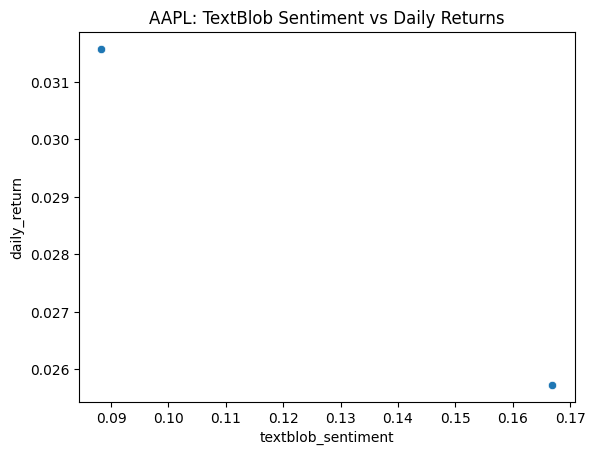

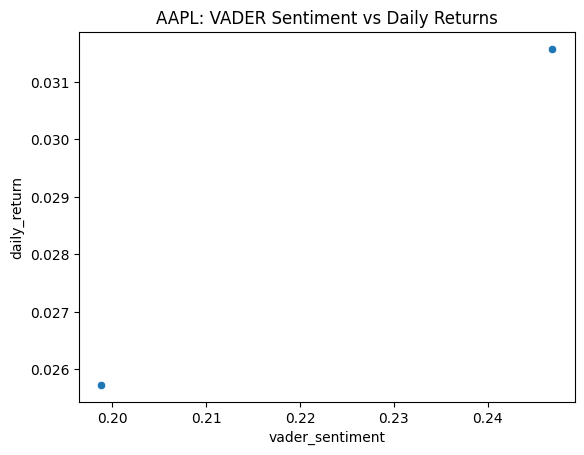

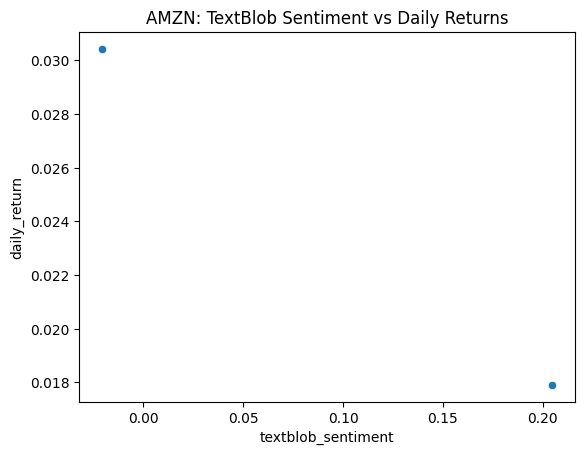

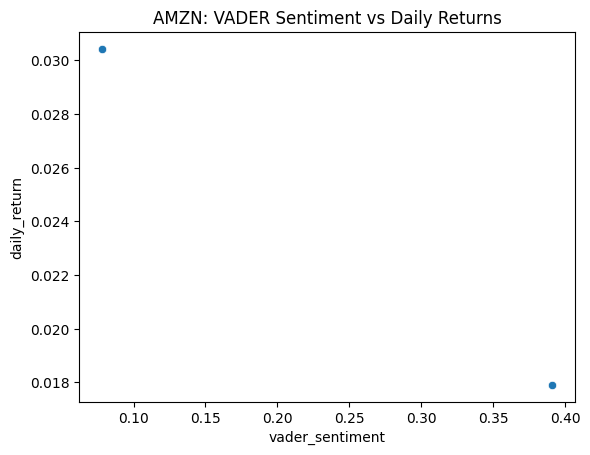

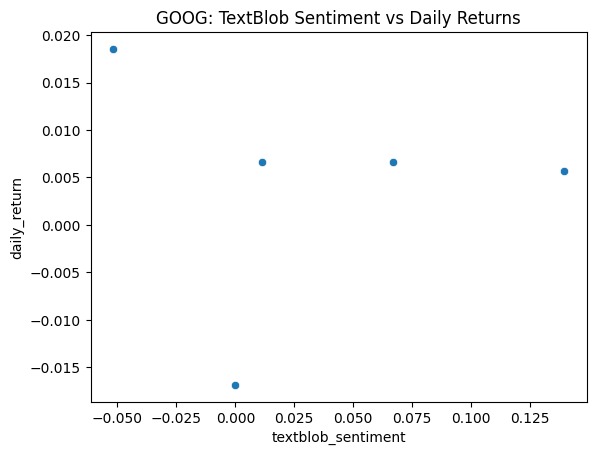

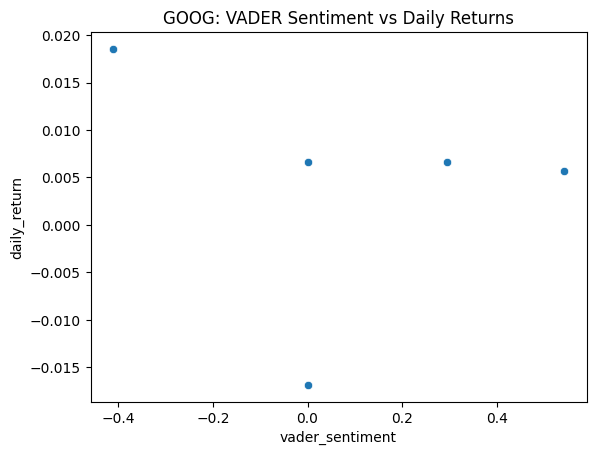

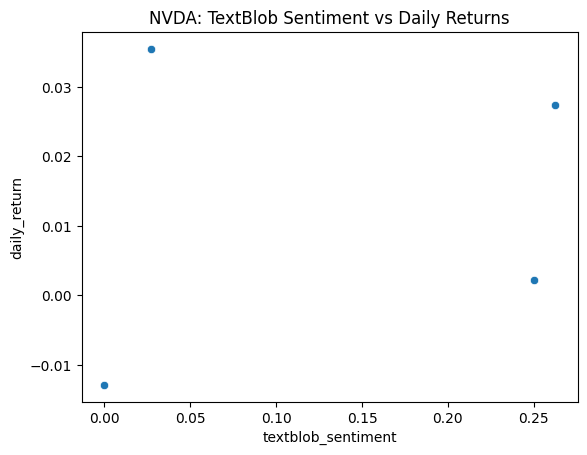

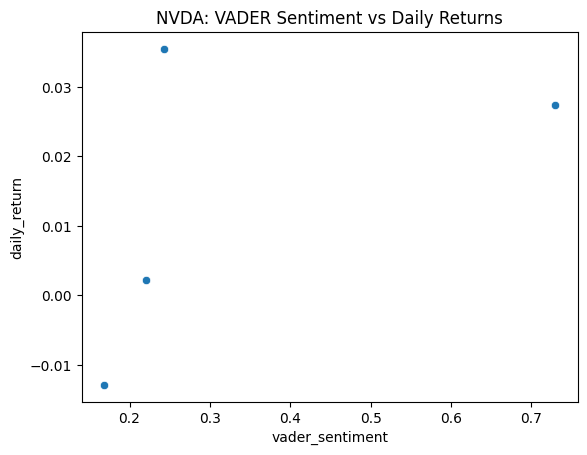

In [21]:
for ticker, df in merged.groupby('stock'):
    sns.scatterplot(data=df, x='textblob_sentiment', y='daily_return')
    plt.title(f"{ticker}: TextBlob Sentiment vs Daily Returns")
    plt.show()
    
    sns.scatterplot(data=df, x='vader_sentiment', y='daily_return')
    plt.title(f"{ticker}: VADER Sentiment vs Daily Returns")
    plt.show()


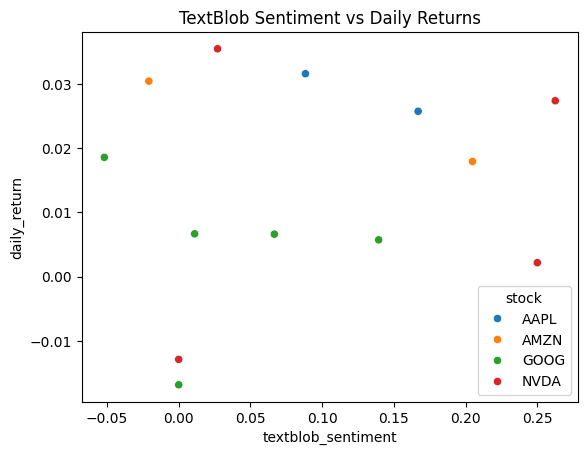

In [17]:

sns.scatterplot(data=merged, x='textblob_sentiment', y='daily_return', hue='stock')
plt.title("TextBlob Sentiment vs Daily Returns")
plt.show()



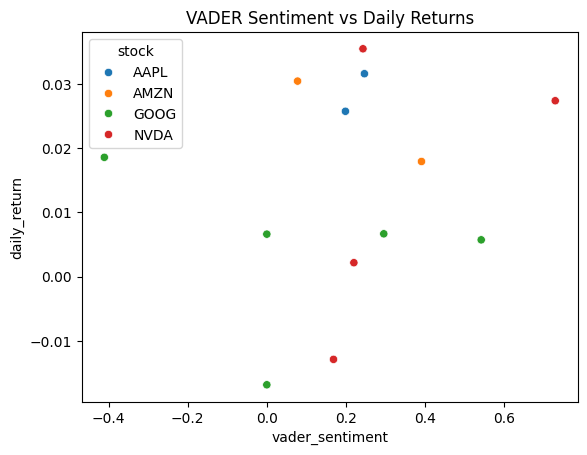

In [18]:
sns.scatterplot(data=merged, x='vader_sentiment', y='daily_return', hue='stock')
plt.title("VADER Sentiment vs Daily Returns")
plt.show()


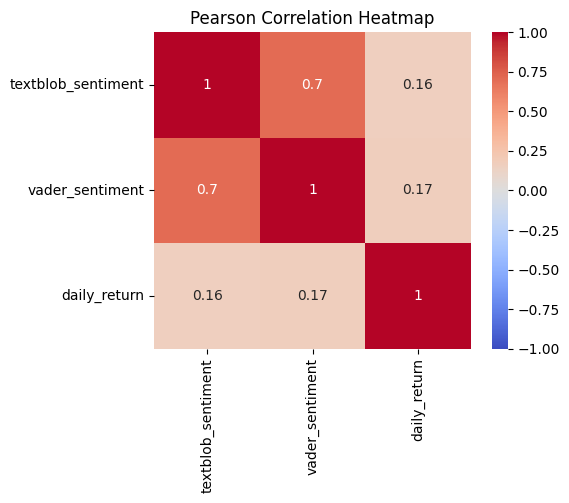

In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()


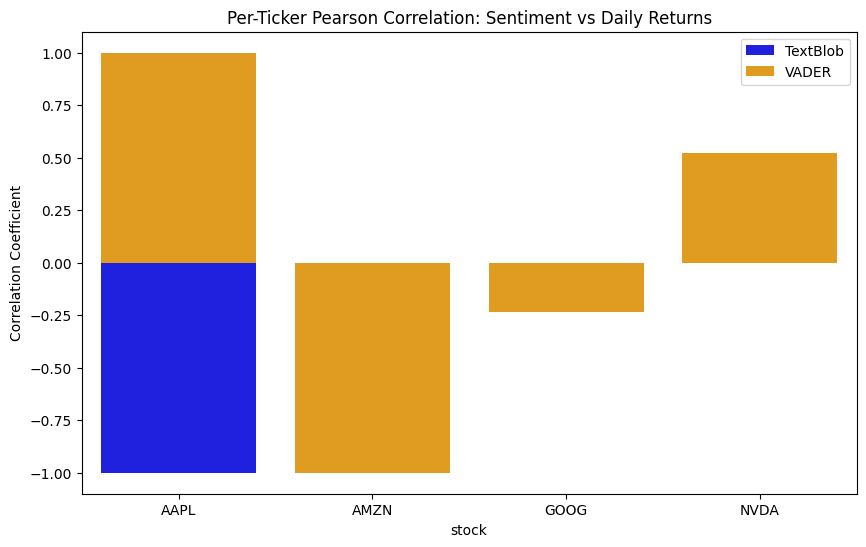

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=summary_df, x='stock', y='pearson_textblob', color='blue', label='TextBlob')
sns.barplot(data=summary_df, x='stock', y='pearson_vader', color='orange', label='VADER')
plt.title("Per-Ticker Pearson Correlation: Sentiment vs Daily Returns")
plt.ylabel("Correlation Coefficient")
plt.legend()
plt.show()


In [ ]:

# Interpretation
- Weak Positive Relationship: Overall sentiment exhibits only a small positive relationship with returns.
- VADER Stronger: VADER correlations are consistently stronger than TextBlob, especially for NVDA.
- Ticker Variability:
- AAPL and AMZN show extreme values (likely due to small sample size or data quirks).
- GOOG shows weak negative correlation.
- NVDA shows moderate positive correlation, especially with VADER.
- Market Noise: Correlations are small, consistent with noisy financial markets.
- Limitations: Correlation ≠ causation; outliers and limited data can distort results.

